In [1]:
using LinearAlgebra

In [4]:
using GLMakie

In [5]:
function hardening_law(u, p)

    s1, s2, s3, h0 = p[1:4]
    
    return @. s1 + s2 * u - s3 * exp(-h0 * u)
end

hardening_law (generic function with 1 method)

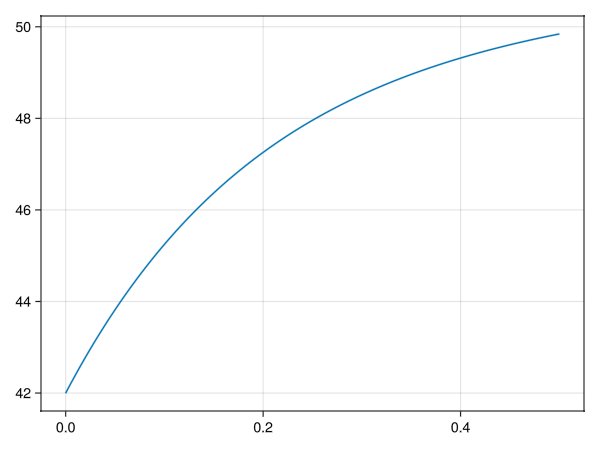

In [16]:
ui = LinRange(0, 0.5, 100)
p = (50.0, 1.0, 8.0, 5)
sig = hardening_law(ui, p)

fig = Figure()
ax = Axis(fig[1,1])
lines!(ax, ui, sig)
fig

In [2]:
function voigt_strain_transformation(A)
    a11, a21, a31, a12, a22, a32, a13, a23, a33 = A

    return [a11 * a11     a12 * a12     a13 * a13    a12 * a13                  a11 * a13                a11 * a12;
            a21 * a21     a22 * a22     a23 * a23    a22 * a23                  a21 * a23                a21 * a22;
            a31 * a31     a32 * a32     a33 * a33    a32 * a33                  a31 * a33                a31 * a32;
           2a21 * a31    2a22 * a32    2a23 * a33    a22 * a33 + a23 * a32      a21 * a33 + a23 * a31    a21 * a32 + a22 * a31;
           2a11 * a31    2a12 * a32    2a13 * a33    a12 * a33 + a13 * a32      a11 * a33 + a13 * a31    a11 * a32 + a12 * a31;
           2a11 * a21    2a12 * a22    2a13 * a23    a12 * a23 + a13 * a22      a11 * a23 + a13 * a21    a11 * a22 + a12 * a21]
end

voigt_strain_transformation (generic function with 1 method)

In [27]:

function rotz(theta)
    s, c = sincosd(theta)
    return [c -s 0;
            s c  0;
            0 0  1]
end

rotz (generic function with 1 method)

In [29]:
R45 = rotz(45.0)
A45 = voigt_strain_transformation(R45)

6×6 Matrix{Float64}:
 0.5   0.5  0.0  -0.0       0.0       -0.5
 0.5   0.5  0.0   0.0       0.0        0.5
 0.0   0.0  1.0   0.0       0.0        0.0
 0.0   0.0  0.0   0.707107  0.707107   0.0
 0.0  -0.0  0.0  -0.707107  0.707107   0.0
 1.0  -1.0  0.0   0.0       0.0        0.0

In [ ]:
function compliance_matrix(; E1 = 1.0,
                             E2 = 1.0,
                             E3 = 1.0,
                             G12 = 1.0,
                            G23 = 1.0,
                            G31 = 1.0,
                            nu12 = nothing,
                            nu23 = nothing,
                            nu13 = nothing,
                            nu21 = nothing,
                            nu32 = nothing,
                            nu31 = nothing)

    @assert !(isnothing(nu12) && isnothing(nu21)) "ν12 or ν21 must be something"
    @assert !(isnothing(nu23) && isnothing(nu32))
    @assert !(isnothing(nu13) &&  isnothing(nu31))

    if isnothing(nu12)
        nu12 = nu21 * E1 / E2
    else
        nu21 = nu12 * E2 / E1
    end
    if isnothing(nu23)
        nu23 = nu32 * E2 / E3
    else
        nu32 = nu23 * E3 / E2
    end
    if isnothing(nu13)
        nu13 = nu31 * E1 / E3
    else
        nu31 = nu13 * E3 / E1
    end

    return [ 1/E1    -nu21/E2      -nu31/E3   0     0     0;
          -nu12/E1     1/E2        -nu32/E3   0     0     0;
          -nu13/E1   -nu23/E2        1/E3     0     0     0;
             0          0             0     1/G23   0     0;
             0          0             0       0    1/G31  0;
             0          0             0       0     0    1/G12]
    
end

compliance_matrix (generic function with 1 method)

In [20]:
mat = (;E1 = 22.1,
        E2 = 9.4,
        E3 =8.8,
        G12 = 7.0,
        G23 = 5.0,
        G31 = 4.5,
        nu12 = 0.3,
        nu32 = 0.2,
        nu31 = 0.05)

(E1 = 22.1, E2 = 9.4, E3 = 8.8, G12 = 7.0, G23 = 5.0, G31 = 4.5, nu12 = 0.3, nu32 = 0.2, nu31 = 0.05)

In [21]:
CL = compliance_matrix(;mat...)

6×6 Matrix{Float64}:
  0.0452489   -0.0135747  -0.00568182  0.0  0.0       0.0
 -0.0135747    0.106383   -0.0227273   0.0  0.0       0.0
 -0.00568182  -0.0227273   0.113636    0.0  0.0       0.0
  0.0          0.0         0.0         0.2  0.0       0.0
  0.0          0.0         0.0         0.0  0.222222  0.0
  0.0          0.0         0.0         0.0  0.0       0.142857

In [36]:
e1 = [1e-3, 0.0, 0.0, 0.0, 0.0, 0.0]
s11 = dot(CL[1, :], e1)
s11 / e1[1]

e26 = CL[2:6, :] \ zeros(5)

6-element Vector{Float64}:
  0.0
  0.0
  0.0
 -0.0
 -0.0
 -0.0

In [24]:
eps = [1e-3, 0, 0, 0, 0,0 ]
C = zeros(6,6)
for i in 1:6
    eps = zeros(6)
    eps[i] = 1e-3
    sig = CL \ eps
    C[:, i] .= sig ./ eps[i]
end
C


6×6 Matrix{Float64}:
 23.3428    3.37201  1.84154  0.0  0.0  0.0
  3.37201  10.3067   2.22993  0.0  0.0  0.0
  1.84154   2.22993  9.33806  0.0  0.0  0.0
  0.0       0.0      0.0      5.0  0.0  0.0
  0.0       0.0      0.0      0.0  4.5  0.0
  0.0       0.0      0.0      0.0  0.0  7.0

In [26]:
norm(CL .- inv(C))

2.6336964641606203e-17

In [31]:
e11 = [1.0, 0, 0, 0, 0, 0]
sig45 = A45' * inv(CL) * A45 * e11

6-element Vector{Float64}:
 17.09838281365
  3.0983828136499945
  2.0357392298517176
  0.0
  0.0
 -3.259043157071873